In [ ]:
# =============================
# STEP 1: Mount Google Drive
# =============================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =============================
# STEP 2: Import Libraries
# =============================
import pandas as pd
import numpy as np
import lightgbm as lgb # for LightGBM modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve
import gc # for memory cleanup
import copy # to deepcopy models across rounds
import torch # for PyTorch model inference
from transformers import AutoTokenizer, AutoModel # for TinyBERT tokenizer and model

In [ ]:
# =============================
# STEP 3: Load CERT Dataset
# =============================
logon_df = pd.read_csv("/content/drive/My Drive/extracted_r5.1/r5.1/logon.csv")
file_df = pd.read_csv("/content/drive/My Drive/extracted_r5.1/r5.1/file.csv")
decoy_df = pd.read_csv("/content/drive/My Drive/extracted_r5.1/r5.1/decoy_file.csv")

print("Logon Shape:", logon_df.shape)
print("File Shape:", file_df.shape)
print("Decoy File Shape:", decoy_df.shape)

Logon Shape: (1829996, 5)
File Shape: (947613, 9)
Decoy File Shape: (10961, 2)


In [ ]:
# =============================
# STEP 4: Feature Engineering (Logon)
# =============================
# Extract behavioral features from logon logs:
# login frequency, devices used, failed logons, weekend usage, session duration

logon_df['date'] = pd.to_datetime(logon_df['date'], errors='coerce')
logon_df.dropna(subset=['date'], inplace=True)

# Login Frequency
logon_freq = logon_df.groupby('user')['date'].count().reset_index()
logon_freq.columns = ['user', 'login_frequency']

# Unique Devices
unique_devices = logon_df.groupby('user')['pc'].nunique().reset_index()
unique_devices.columns = ['user', 'num_unique_devices']

# Failed Logon Attempts
failed_logons = logon_df[logon_df['activity'] == 'LogonFailure']
failed_attempts = failed_logons.groupby('user')['activity'].count().reset_index()
failed_attempts.columns = ['user', 'failed_logon_attempts']

# Count weekend logons per user (Saturday = 5, Sunday = 6)
logon_df['weekday'] = logon_df['date'].dt.weekday
weekend_logons = logon_df[logon_df['weekday'] >= 5].groupby('user')['activity'].count().reset_index()
weekend_logons.columns = ['user', 'weekend_logon_count']

# Compute average session duration by taking time difference between logon and logoff
logon_filtered = logon_df[logon_df['activity'].isin(['Logon', 'Logoff'])]
logon_filtered['session_duration'] = logon_filtered.groupby(['user', 'pc'])['date'].diff()
session_durations = logon_filtered[logon_filtered['activity'] == 'Logoff'][['user', 'session_duration']]
session_durations['session_duration'] = session_durations['session_duration'].dt.total_seconds()
avg_session_duration = session_durations.groupby('user')['session_duration'].mean().reset_index()
avg_session_duration.columns = ['user', 'avg_session_duration']

In [ ]:
# =============================
# STEP 5: Feature Engineering (File)
# =============================

# Extract features from file access logs:
# total files accessed, sensitive file access, and file access timing

# Count total number of file accesses per user
file_access = file_df.groupby('user')['filename'].count().reset_index()
file_access.columns = ['user', 'total_file_accesses']

# Count accesses to sensitive file types (.pdf, .doc, etc.)
#Internal reports, financial data
sensitive_files = file_df[file_df['filename'].str.endswith(('.pdf', '.doc', '.docx', '.exe'))]
sensitive_access = sensitive_files.groupby('user')['filename'].count().reset_index()
sensitive_access.columns = ['user', 'sensitive_file_accesses']

# Compute average file access hour per user
file_df['date'] = pd.to_datetime(file_df['date'], errors='coerce')
file_df.dropna(subset=['date'], inplace=True)
file_df['hour'] = file_df['date'].dt.hour
file_access_hour = file_df.groupby('user')['hour'].mean().reset_index()
file_access_hour.columns = ['user', 'avg_file_access_hour']

In [ ]:
# =============================
# STEP 6: Merge Features
# =============================

# Combine all extracted behavioral features into a single dataframe

features_df = logon_freq.merge(unique_devices, on='user', how='left')
features_df = features_df.merge(failed_attempts, on='user', how='left')
features_df = features_df.merge(weekend_logons, on='user', how='left')
features_df = features_df.merge(avg_session_duration, on='user', how='left')
features_df = features_df.merge(file_access, on='user', how='left')
features_df = features_df.merge(sensitive_access, on='user', how='left')
features_df = features_df.merge(file_access_hour, on='user', how='left')
features_df = features_df.fillna(0)

In [ ]:
# =============================
# STEP 7: Label Users
# =============================

# Mark users who logged into decoy PCs as malicious (label = 1), rest are benign (label = 0)

decoy_pcs = decoy_df['pc'].unique().tolist()
malicious_logons = logon_df[logon_df['pc'].isin(decoy_pcs)]
malicious_users = malicious_logons['user'].unique().tolist()
features_df['label'] = features_df['user'].apply(lambda x: 1 if x in malicious_users else 0)

print("Label distribution:")
print(features_df['label'].value_counts())

Label distribution:
label
1    1698
0     302
Name: count, dtype: int64


In [ ]:
# =============================
# STEP 8: Prepare Logon Sequences for TinyBERT
# =============================

# Construct a sequence string for each user combining their activity, PC, and hour

user_sequences = {}

for user, group in logon_df.groupby('user'):
    seq = []
    for _, row in group.iterrows():
        seq.append(f"{row['activity']} {row['pc']} {row['date'].hour}H")
    user_sequences[user] = " → ".join(seq)

In [ ]:
# =============================
# STEP 9: Load TinyBERT Model
# =============================

# Load TinyBERT for generating behavior-aware embeddings from user sequences

# Load pretrained TinyBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModel.from_pretrained("prajjwal1/bert-tiny")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

In [ ]:
# =============================
# STEP 10: Generate Embeddings
# =============================

# Convert each user's sequence to a fixed-size embedding using TinyBERT

user_embeddings = {}

for user, seq in user_sequences.items():
    inputs = tokenizer(seq, return_tensors='pt', truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    user_embeddings[user] = embedding

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

In [ ]:
# =============================
# STEP 11: Merge Embeddings with Features
# =============================

# Convert user embeddings into a dataframe and merge with feature set

embedding_df = pd.DataFrame.from_dict(user_embeddings, orient='index')
embedding_df.reset_index(inplace=True)
embedding_df.columns = ['user'] + [f'emb_{i}' for i in range(embedding_df.shape[1]-1)]

features_df = features_df.merge(embedding_df, on='user', how='left')
features_df = features_df.fillna(0)  # Handle missing users

In [ ]:
# =============================
# STEP 12: Federated Boosting Multi-Round Setup
# =============================

# Simulate 3 clients in a federated setting using data splits

num_clients = 3
client_dfs = np.array_split(features_df.sample(frac=1, random_state=42), num_clients)

client_models = []
client_weights = []
feature_cols = [col for col in features_df.columns if col not in ['user', 'label']]

# LightGBM parameter template for all clients
params_template = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.02,
    'max_depth': 8,
    'verbose': -1
}

num_rounds = 3  # 3-round FedBoost baseline

# ---- Initial Client Training ----
for i, client_data in enumerate(client_dfs):
    print(f"\n[Round 1] Training Client {i+1}...")
    X_client = client_data[feature_cols]
    y_client = client_data['label']

    neg = len(y_client[y_client == 0])
    pos = len(y_client[y_client == 1])
    scale_pos_weight = (neg / max(1, pos))

    params = params_template.copy()
    params['scale_pos_weight'] = scale_pos_weight

    train_data = lgb.Dataset(X_client, label=y_client)
    model = lgb.train(params, train_data, num_boost_round=150)

    client_models.append(model)
    client_weights.append(len(client_data))
    gc.collect()

In [ ]:
# =============================
# STEP 13: Multi-Round Aggregation
# =============================

# Aggregate client predictions and continue training collaboratively over multiple rounds

for round_num in range(2, num_rounds + 1):
    print(f"\n[Round {round_num}] Aggregating & Re-training Clients...")

    # Aggregate predictions to redistribute knowledge
    total_weight = sum(client_weights)
    def global_predict_weighted(X):
        preds = np.zeros(len(X))
        for i, model in enumerate(client_models):
            preds += (client_weights[i]/total_weight) * model.predict(X)
        return preds

    # Redistribute: Continue training
    updated_models = []
    for i, client_data in enumerate(client_dfs):
        X_client = client_data[feature_cols]
        y_client = client_data['label']

        preds_from_others = global_predict_weighted(X_client)
        preds_from_others = np.clip(preds_from_others, 1e-6, 1-1e-6)  # avoid log loss error

        # Continue training using previous model + init_score
        train_data = lgb.Dataset(X_client, label=y_client, init_score=preds_from_others)
        model = lgb.train(params_template, train_data, num_boost_round=100, init_model=client_models[i])
        updated_models.append(model)

    client_models = copy.deepcopy(updated_models)
    gc.collect()


[Round 2] Aggregating & Re-training Clients...

[Round 3] Aggregating & Re-training Clients...


In [ ]:
# =============================
# STEP 14: Global Evaluation + Threshold Tuning
# =============================

# Evaluate the final global model and apply optimal threshold tuning

X = features_df[feature_cols]
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

total_weight = sum(client_weights)
def global_predict(X_test):
    preds = np.zeros(len(X_test))
    for i, model in enumerate(client_models):
        preds += (client_weights[i]/total_weight) * model.predict(X_test)
    return preds

global_preds = global_predict(X_test)
print("\nROC-AUC:", roc_auc_score(y_test, global_preds))

# ---- Threshold Optimization ----
precision, recall, thresholds = precision_recall_curve(y_test, global_preds)
optimal_idx = np.argmax(2 * (precision * recall) / (precision + recall))
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Apply optimized threshold
final_preds = (global_preds >= optimal_threshold).astype(int)
print(classification_report(y_test, final_preds))


ROC-AUC: 0.997035412605588
Optimal Threshold: 0.72
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        76
           1       1.00      0.99      1.00       324

    accuracy                           0.99       400
   macro avg       0.99      1.00      0.99       400
weighted avg       1.00      0.99      1.00       400



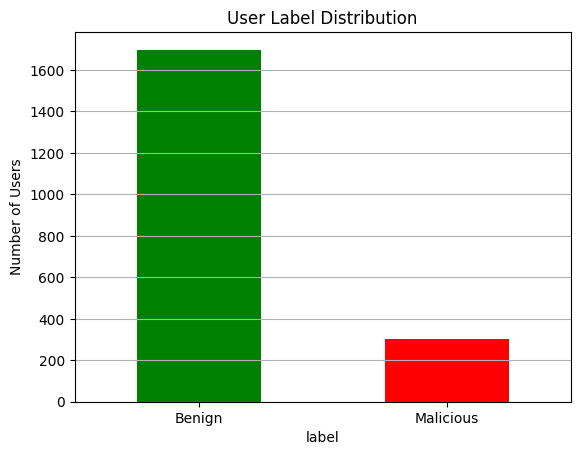

In [ ]:
import matplotlib.pyplot as plt

features_df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("User Label Distribution")
plt.xticks(ticks=[0,1], labels=["Benign", "Malicious"], rotation=0)
plt.ylabel("Number of Users")
plt.grid(axis='y')
plt.show()

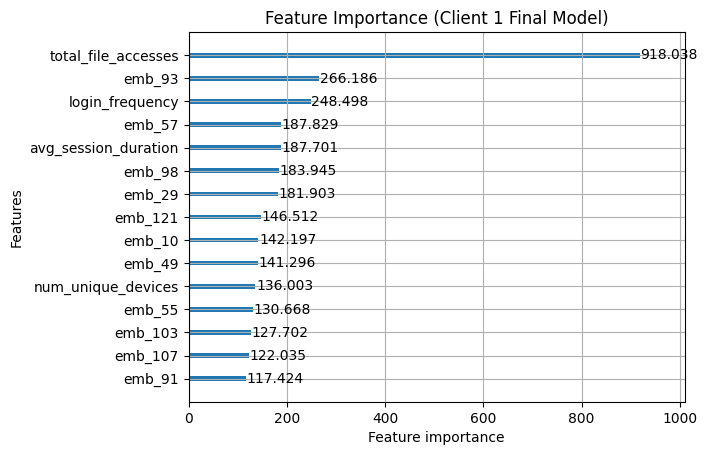

In [ ]:
lgb.plot_importance(client_models[0], max_num_features=15, importance_type='gain')
plt.title("Feature Importance (Client 1 Final Model)")
plt.show()

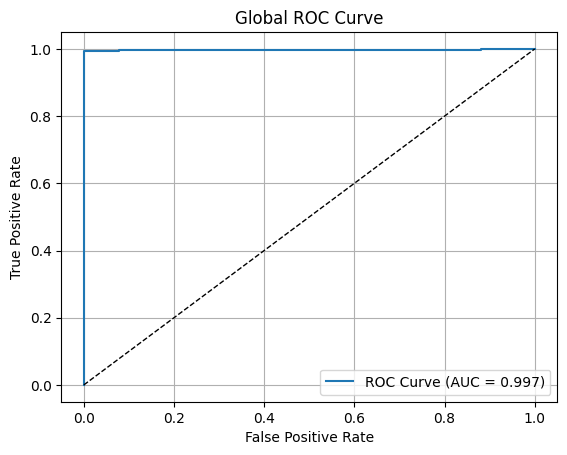

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, global_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Global ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

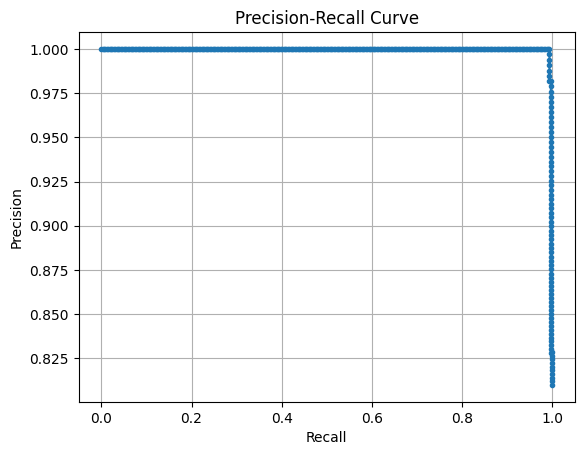

In [ ]:
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

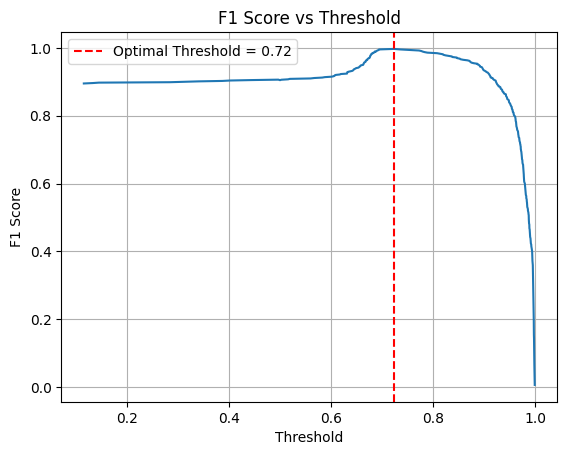

In [ ]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
plt.plot(thresholds, f1_scores[:-1])
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

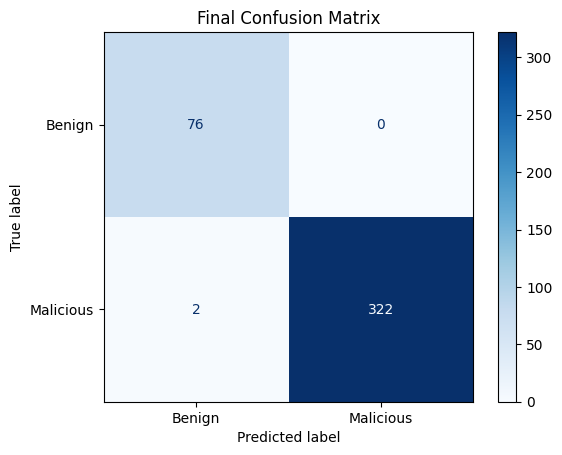

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
disp.plot(cmap='Blues')
plt.title("Final Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score, brier_score_loss, log_loss

print("Matthews Corrcoef:", matthews_corrcoef(y_test, final_preds))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, final_preds))
print("Cohen’s Kappa:", cohen_kappa_score(y_test, final_preds))
print("Brier Score:", brier_score_loss(y_test, global_preds))
print("Log Loss:", log_loss(y_test, global_preds))

Matthews Corrcoef: 0.9840449241720914
Balanced Accuracy: 0.9969135802469136
Cohen’s Kappa: 0.9839176584110646
Brier Score: 0.07633031722518918
Log Loss: 0.22122455634708935


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

for i, client_data in enumerate(client_dfs):
    X_client = client_data[feature_cols]
    y_client = client_data['label']
    preds = client_models[i].predict(X_client)
    pred_labels = (preds >= optimal_threshold).astype(int)

    print(f"\n[Client {i+1}]")
    print("Precision:", precision_score(y_client, pred_labels))
    print("Recall:", recall_score(y_client, pred_labels))
    print("F1 Score:", f1_score(y_client, pred_labels))


[Client 1]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

[Client 2]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

[Client 3]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


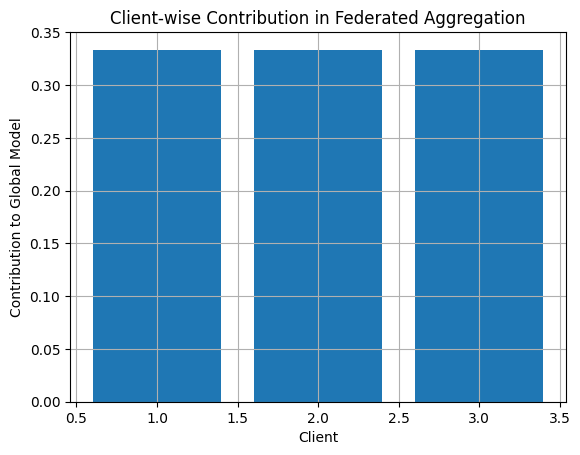

In [ ]:
client_contribution = [w/sum(client_weights) for w in client_weights]
plt.bar(range(1, len(client_weights)+1), client_contribution)
plt.xlabel("Client")
plt.ylabel("Contribution to Global Model")
plt.title("Client-wise Contribution in Federated Aggregation")
plt.grid(True)
plt.show()

In [ ]:
baseline_model = lgb.train(params_template, lgb.Dataset(X_train, label=y_train), num_boost_round=150)
baseline_preds = baseline_model.predict(X_test)

# Compare ROC-AUC
from sklearn.metrics import roc_auc_score
print("Centralized AUC:", roc_auc_score(y_test, baseline_preds))
print("Federated AUC:", roc_auc_score(y_test, global_preds))

Centralized AUC: 0.6885964912280702
Federated AUC: 0.997035412605588


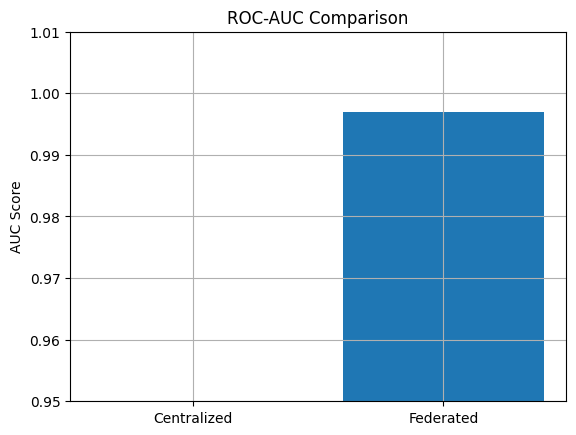

In [ ]:
auc_vals = [roc_auc_score(y_test, baseline_preds), roc_auc_score(y_test, global_preds)]
labels = ['Centralized', 'Federated']
plt.bar(labels, auc_vals)
plt.title("ROC-AUC Comparison")
plt.ylabel("AUC Score")
plt.ylim(0.95, 1.01)
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

baseline_labels = (baseline_preds >= optimal_threshold).astype(int)

# Confusion matrix for McNemar
tb = pd.crosstab(final_preds, baseline_labels)
result = mcnemar(tb, exact=True)
print('McNemar Test p-value:', result.pvalue)

McNemar Test p-value: 5.917714592428801e-10
